**Author**: Justine Debelius<br>
**email**: jdebelius@ucsd.edu<br>
**enviroment**: agp_2017<br>
**Date**: 16 May 2017<br>
**Update**: 29 November 2017

This notebook will build a linear regression comparing the alpha diversity of participants in the American Gut to covariates of interest. We'll build the list using the ten most significant variables from the alpha diversity effect size calculations, excluding longitude and latitude since this value is captured in the country covariate better than it is captured in the effect size calculation. We'll additionally include sex, to explore the interaction between sex and age. We'll include the the bloom percentage, to help address differences in shipping.

* Race (`race`)
* The sequencing run (`center_project_name`)
* How often the participant uses the bathroom daily (`bowel_movement_frequency`)
* The number of types of plants consumed (`types_of_plants`)
* The participant age (`age_cat` in effect size, `age_corrected` in regression)
* The participant's educational history (`level_of_education`)
* The participant's country of residence (`country`)
* How often the participant eats vegetables (`vegetable_frequency`)
* How long since the participant too antibiotics (`antibiotic_history`)
* How many alcoholic beverages the participant consumes when they drink (`drinks_per_session`)

We'll start by building a subset of participants who include these covariates, and then build a model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import scipy
import skbio
import seaborn as sn
import statsmodels.api as sms
import statsmodels.formula.api as smf

%matplotlib inline

We'll start by loading the study metadata and converting the alpha diversity, age, and BMI to floats.

In [2]:
map_ = pd.read_csv('./ag_map_with_alpha.txt', sep='\t', dtype=str)
map_.set_index('#SampleID', inplace=True)

map_.replace('Unspecified', np.nan, inplace=True)

In [3]:
map_['faiths_pd_1250'] = map_['faiths_pd_1250'].astype(float)

In [4]:
map_['age_corrected'] = map_['age_corrected'].astype(float)
map_.loc[map_['age_corrected'] > 105, 'age_corrected'] = np.nan

map_['bmi_corrected'] = map_['bmi_corrected'].astype(float)

Next, we'll load the bloom percentage file, and add that to the mapping file.

In [5]:
bloom = pd.read_csv('./ag-bloom-fractions-125nt.txt', sep='\t', dtype=str)
bloom.set_index('#SampleID', inplace=True)

In [6]:
map_['bloom_fraction'] = bloom['bloom_fraction'].astype(float)

We'll start by performing inclusive remappings for known smaller categories, including bowel_movement_frequency, antibiotic_history, and vegetable frequency. We'll also address a known issue with education level in the dataset, combing data into a single category describing anything less than a bachelor's degree as such.

In [7]:
clean_up = {
    "antibiotic_history": {"Week": "Month"},
    'bowel_movement_frequency': {'Four': 'Four or more', 
                                 'Five or more': 'Four or more'},
    'vegetable_frequency': {'Never': "Less than weekly",
                            'Rarely (less than once/week)': "Less than weekly"},
    'level_of_education': {'Did not complete high school': 'High school or less',
                           'High School or GED equilivant': 'High school or less',
                           'Some college or technical school': 'Less than bachelors',
                           "Associate's degree": 'Less than bachelors',
                           "Some graduate school or professional": "Bachelor's degree"
                           }
    }
map_.replace(clean_up, inplace=True)

We're going to only look at samples from the US, UK, Australia and Canada, since these represent about 92% of the samples in the data set. We'll also limit the data to participants who have provided their sex and male and female.

In [8]:
def filter_map(x):
    race = x['race'] in {'Caucasian', 'Asian or Pacific Islander', 'Other'}
    country = x['country'] in {'USA', 'United Kingdom', 'Canada', 'Australia'}
    sex = x['sex'] in {'male', 'female'}    
    return country & sex & race

In [9]:
study_columns = [
    'race',
    'center_project_name',
    'bowel_movement_frequency',
    'types_of_plants',
    'level_of_education',
    'country',
    'vegetable_frequency',
    'antibiotic_history',
    'drinks_per_session',
    'sex',
    'age_corrected',
    'faiths_pd_1250',
    'bloom_fraction'
    ]

In [10]:
fmap_ = map_.loc[map_.apply(filter_map, axis=1)]
dmap_ = fmap_[study_columns].dropna()

We'll also filter the map to remove any center project name category with less than 100 samples, so that if we chose to include it in the regression, we have enough groups that it won't lead to weird behavior.

In [11]:
cpn_counts = dmap_['center_project_name'].value_counts()
cpn_filter = set(cpn_counts.index[cpn_counts > 75])

In [12]:
smap_ = dmap_.loc[dmap_['center_project_name'].apply(lambda x: x in cpn_filter)]

We're going to code the data using numeric codeing, since this will be easier for patsy to handle.
We'll also do some work to build combinations.

We're going to combine the antibiotics in the last week and in the last month. <br>
For both IBD and IBS, we will combine people who were idagnosed by an alternative medicine practioner or self diagnosed individuals into a different category.

In [13]:
numeric_coding = {
    'race': {'Caucasian': 0,
             'Asian or Pacific Islander': 1,
             'Other': 2,
             },
    'center_project_name': {'AGag36': 0,
                            'AGag35': 1,
                            'AGag33': 2,
                            'AGag34': 3,
                            'AGagFerm': 4,
                            'AG3dMouse': 5,
                            },
    'bowel_movement_frequency': {'Less than one': 0,
                                 'One': 1,
                                 'Two': 2,
                                 'Three': 3,
                                 'Four or more': 4,
                                 },
    'types_of_plants': {'Less than 5': 0,
                        '6 to 10': 1,
                        '11 to 20': 2,
                        '21 to 30': 3,
                        'More than 30': 4,
                        },
    'level_of_education': {'High school or less': 0,
                           'Less than bachelors': 1,
                           "Bachelor's degree": 2,
                           'Graduate or Professional degree': 3,
                           },
    'country': {'USA': 0,
                'United Kingdom': 1,
                'Canada': 2,
                'Australia': 3,
                },
    'vegetable_frequency': {'Less than weekly': 0,
                            'Occasionally (1-2 times/week)': 1,
                            'Regularly (3-5 times/week)': 2,
                            'Daily': 3,
                            },
    'antibiotic_history': {'I have not taken antibiotics in the past year.': 0,
                           'Year': 1,
                           '6 months': 2,
                           'Month': 3,
                           },
    'drinks_per_session': {"I don't drink": 0,
                           '1': 1,
                           '1-2': 2,
                           '2-3': 3,
                           '3-4': 4,
                           '4+': 4,
                            },
    'sex': {'female': 0, 
            'male': 1},
    }

In [14]:
smap_numeric = smap_.replace(numeric_coding)

In [15]:
smap_numeric['ln_age'] = np.log(smap_numeric['age_corrected'])

Next, we'll build a regression including the covariate we're potentially interested in.

Next, we'll build a function that will let us preform a step-wise selection based on a decrease in the AIC, an increase in the adjusted $R^{2}$ and not blowing up the condition number.

In [16]:
fit0 = smf.ols('faiths_pd_1250 ~ bloom_fraction', data=smap_numeric).fit()
print(fit0.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     10.17
Date:                Wed, 29 Nov 2017   Prob (F-statistic):            0.00147
Time:                        20:53:49   Log-Likelihood:                -2856.5
No. Observations:                1072   AIC:                             5717.
Df Residuals:                    1070   BIC:                             5727.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         13.5380      0.135    100.

In [17]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(race)', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     21.66
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           1.28e-13
Time:                        20:53:49   Log-Likelihood:                -2829.9
No. Observations:                1072   AIC:                             5668.
Df Residuals:                    1068   BIC:                             5688.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         13.8181      0.137    100.

In [18]:
fit2 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(race) + C(center_project_name)', 
               data=smap_numeric).fit()
print(fit2.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     10.46
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           3.40e-14
Time:                        20:53:50   Log-Likelihood:                -2820.9
No. Observations:                1072   AIC:                             5660.
Df Residuals:                    1063   BIC:                             5705.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept         

In [19]:
fit3 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(race) + C(center_project_name)'
               ' + C(bowel_movement_frequency)', 
               data=smap_numeric).fit()
print(fit3.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     10.36
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           1.49e-19
Time:                        20:53:50   Log-Likelihood:                -2802.0
No. Observations:                1072   AIC:                             5630.
Df Residuals:                    1059   BIC:                             5695.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

In [20]:
fit4 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(race) + C(center_project_name)'
               ' + C(bowel_movement_frequency) + C(types_of_plants)', 
               data=smap_numeric).fit()
print(fit4.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     10.14
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           3.23e-24
Time:                        20:53:50   Log-Likelihood:                -2784.8
No. Observations:                1072   AIC:                             5604.
Df Residuals:                    1055   BIC:                             5688.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

In [21]:
fit5 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(race) + C(center_project_name)'
               ' + C(bowel_movement_frequency) + C(types_of_plants)'
               ' + C(level_of_education)', 
               data=smap_numeric).fit()
print(fit5.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     9.124
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           1.16e-24
Time:                        20:53:50   Log-Likelihood:                -2779.8
No. Observations:                1072   AIC:                             5600.
Df Residuals:                    1052   BIC:                             5699.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

In [22]:
fit6 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(race) + C(center_project_name)'
               ' + C(bowel_movement_frequency) + C(types_of_plants)'
               ' + C(level_of_education) + C(country)', 
               data=smap_numeric).fit()
print(fit6.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     11.10
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           6.50e-35
Time:                        20:53:50   Log-Likelihood:                -2749.4
No. Observations:                1072   AIC:                             5545.
Df Residuals:                    1049   BIC:                             5659.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

In [23]:
fit7 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(race) + C(center_project_name)'
               ' + C(bowel_movement_frequency) + C(types_of_plants)'
               ' + C(level_of_education) + C(country) + C(vegetable_frequency)', 
               data=smap_numeric).fit()
print(fit7.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     9.927
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           4.18e-34
Time:                        20:53:50   Log-Likelihood:                -2747.4
No. Observations:                1072   AIC:                             5547.
Df Residuals:                    1046   BIC:                             5676.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

In [24]:
fit8 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(race) + C(center_project_name)'
               ' + C(bowel_movement_frequency) + C(types_of_plants)'
               ' + C(level_of_education) + C(country) + C(vegetable_frequency)'
               ' + C(antibiotic_history)', 
               data=smap_numeric).fit()
print(fit8.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     9.940
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           1.93e-37
Time:                        20:53:50   Log-Likelihood:                -2734.7
No. Observations:                1072   AIC:                             5527.
Df Residuals:                    1043   BIC:                             5672.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

In [25]:
fit9 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(race) + C(center_project_name)'
               ' + C(bowel_movement_frequency) + C(types_of_plants)'
               ' + C(level_of_education) + C(country) + C(vegetable_frequency)'
               ' + C(antibiotic_history) + C(drinks_per_session)', 
               data=smap_numeric).fit()
print(fit9.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     9.016
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           3.42e-37
Time:                        20:53:50   Log-Likelihood:                -2730.2
No. Observations:                1072   AIC:                             5526.
Df Residuals:                    1039   BIC:                             5691.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

In [26]:
fit10 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(race) + C(center_project_name)'
               ' + C(bowel_movement_frequency) + C(types_of_plants)'
               ' + C(level_of_education) + C(country) + C(vegetable_frequency)'
               ' + C(antibiotic_history) + C(drinks_per_session)'
               ' + age_corrected', 
               data=smap_numeric).fit()
print(fit10.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     9.327
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           1.14e-39
Time:                        20:53:50   Log-Likelihood:                -2722.3
No. Observations:                1072   AIC:                             5513.
Df Residuals:                    1038   BIC:                             5682.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

In [27]:
fit11 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(race) + C(center_project_name)'
               ' + C(bowel_movement_frequency) + C(types_of_plants)'
               ' + C(level_of_education) + C(country) + C(vegetable_frequency)'
               ' + C(antibiotic_history) + C(drinks_per_session)'
               ' + ln_age', 
               data=smap_numeric).fit()
print(fit11.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     9.362
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           7.62e-40
Time:                        20:53:50   Log-Likelihood:                -2721.9
No. Observations:                1072   AIC:                             5512.
Df Residuals:                    1038   BIC:                             5681.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

In [28]:
fit12 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(race) + C(center_project_name)'
               ' + C(bowel_movement_frequency) + C(types_of_plants)'
               ' + C(level_of_education) + C(country) + C(vegetable_frequency)'
               ' + C(antibiotic_history) + C(drinks_per_session)'
               ' + ln_age + sex', 
               data=smap_numeric).fit()
print(fit12.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     9.078
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           2.35e-39
Time:                        20:53:50   Log-Likelihood:                -2721.9
No. Observations:                1072   AIC:                             5514.
Df Residuals:                    1037   BIC:                             5688.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

In [29]:
fit13 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(race) + C(center_project_name)'
               ' + C(bowel_movement_frequency) + C(types_of_plants)'
               ' + C(level_of_education) + C(country) + C(vegetable_frequency)'
               ' + C(antibiotic_history) + C(drinks_per_session)'
               ' + ln_age * sex', 
               data=smap_numeric).fit()
print(fit13.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     8.894
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           2.63e-39
Time:                        20:53:50   Log-Likelihood:                -2720.7
No. Observations:                1072   AIC:                             5513.
Df Residuals:                    1036   BIC:                             5693.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

We can check the fits by looking at the regression coeffecient, decrease in the AIC, and increase in the condition number.

In [30]:
fits = {0: ('bloom_fraction', fit0),
        1: ('race', fit1),
        2: ('center_project_name', fit2),
        3: ('bowel_movement_frequency', fit3),
        4: ('types_of_plants', fit4),
        5: ('level_of_education', fit5),
        6: ('country', fit6),
        7: ('vegetable_frequency', fit7),
        8: ('antibiotic_history', fit8),
        9: ('drinks_per_session', fit9),
        10: ('age_corrected', fit10),
        11: ('ln_age', fit11),
        12: ('+ sex', fit12),
        14: ('ln_age * sex', fit13),
        }

In [31]:
fit_summary = pd.DataFrame.from_dict(
    {num: {'name': name,
           'correlation': fit.rsquared,
           'adj_correlation': fit.rsquared_adj,
           'cond_no': fit.condition_number,
           'aic': fit.aic,
           'p-values': fit.f_pvalue,
           }
     for num, (name, fit) in fits.items()},
    orient='index')

In [32]:
pd.DataFrame.from_dict(fit_summary)

,name,correlation,adj_correlation,cond_no,aic,p-values
0,bloom_fraction,0.009414,0.008488,3.661604,5716.909141,1.470072e-03
1,race,0.057341,0.054693,5.543837,5667.746544,1.281518e-13
2,center_project_name,0.072981,0.066005,6.604768,5659.810689,3.402842e-14
3,bowel_movement_frequency,0.105051,0.094910,11.168799,5630.069045,1.487158e-19
4,types_of_plants,0.133321,0.120178,12.783683,5603.659118,3.228868e-24
5,level_of_education,0.141478,0.125972,15.285403,5599.522653,1.156634e-24
6,country,0.188817,0.171804,15.971317,5544.720647,6.500985e-35
7,vegetable_frequency,0.191767,0.172450,20.376670,5546.813879,4.177836e-34
8,antibiotic_history,0.210631,0.189440,20.716366,5527.497869,1.926245e-37
9,drinks_per_session,0.217334,0.193229,21.537844,5526.355116,3.416514e-37


Based on the aic, R<sup>2</sup>, and condition number, the best fit for this model is fit 11, with an equation of:

$faiths\_pd = bloom\_fraction + race + center\_project\_name + bowel\_movement\_frequency + types\_of\_plants + 
level\_of\_education + country + vegetable\_frequency + antibiotic\_history + drinks\_per\_session + ln(age)$

In [33]:
print(fit11.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     9.362
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           7.62e-40
Time:                        20:53:50   Log-Likelihood:                -2721.9
No. Observations:                1072   AIC:                             5512.
Df Residuals:                    1038   BIC:                             5681.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

/Users/jwdebelius/miniconda3/envs/agp_2017/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


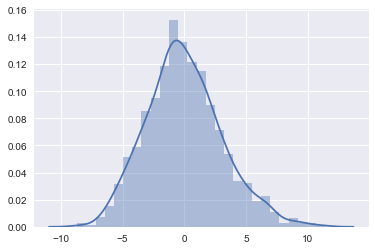

In [34]:
sn.distplot(fit11.resid)